# Environment

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from scipy import stats
import seaborn as sns
from tqdm import tqdm
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

import sys
import os
import gc

# Get the current working directory
current_dir = os.getcwd()

# Construct the path to the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))

# Add the parent directory to sys.path
sys.path.insert(0, parent_dir)

import Helper as fn

# Set random seed for reproducibility
np.random.seed(42)

cluster = True

In [2]:
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [3]:
if cluster:
    wd_dir = '/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_microglia/GSE98969'
else:
    wd_dir = '/home/michal/WSL_GitHub/SRF_microglia/GSE98969'
os.chdir(wd_dir)

In [4]:
if cluster:
    sharon_dir = '/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_microglia/Sharon_RNA/samples/all/runs/all/fastq/merge-by-read/trimmed/trimmomatic/mapped/STAR/merged/featureCounts/merged'
else:
    sharon_dir = '/home/michal/WSL_GitHub/SRF_microglia/data/sharon_rna'

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
x <- c(1, 2, 3, 4, 5)
mean(x)

[1] 3


# Load GSE98969 data

In [164]:
# Get list of all MARS-seq files
mars_seq_files = glob('./data/extracted/GSM*.txt.gz')
print(mars_seq_files)

['./data/extracted/GSM2629411_AB2327.txt.gz', './data/extracted/GSM2629371_AB1714.txt.gz', './data/extracted/GSM2629398_AB1741.txt.gz', './data/extracted/GSM2629374_AB1717.txt.gz', './data/extracted/GSM2629412_AB2328.txt.gz', './data/extracted/GSM2629354_AB1549.txt.gz', './data/extracted/GSM2629353_AB1548.txt.gz', './data/extracted/GSM2629434_AB2429.txt.gz', './data/extracted/GSM2629444_AB2439.txt.gz', './data/extracted/GSM2629449_AB2444.txt.gz', './data/extracted/GSM2629397_AB1740.txt.gz', './data/extracted/GSM2629415_AB2331.txt.gz', './data/extracted/GSM2629356_AB1551.txt.gz', './data/extracted/GSM2629430_AB2425.txt.gz', './data/extracted/GSM2629364_AB1667.txt.gz', './data/extracted/GSM2629405_AB1864.txt.gz', './data/extracted/GSM2629368_AB1711.txt.gz', './data/extracted/GSM2629343_AB1444.txt.gz', './data/extracted/GSM2629393_AB1736.txt.gz', './data/extracted/GSM2629359_AB1554.txt.gz', './data/extracted/GSM2629422_AB2338.txt.gz', './data/extracted/GSM2629409_AB2325.txt.gz', './data/e

In [165]:
# Read metadata
metadata = pd.read_csv('./data/metadata_csv.csv')
metadata_dict = metadata.set_index('geo_accession').to_dict('index')
metadata_dict[list(metadata_dict.keys())[0]]

{'Treatment': "treatment: Alzheimer's disease",
 'age': 'mouse age: 6 months',
 'region': 'Whole brain',
 'title': 'AB1442',
 'strain': 'strain: 5XFAD',
 'organ': 'organ: Brain'}

In [166]:
# Function to read a single MARS-seq file
def read_mars_seq_file(filename):
    df = pd.read_csv(filename, sep='\t', compression='gzip', index_col=0)
    return df


In [167]:
# Read all MARS-seq files and store them in a list
adatas = []
for file in mars_seq_files:
    df = read_mars_seq_file(file)
    adata = ad.AnnData(df.T)
    adata.var_names_make_unique()
    
    # Extract GSM ID from filename
    gsm_id = os.path.basename(file).split('_')[0]
    
    # Add metadata
    if gsm_id in metadata_dict:
        for key, value in metadata_dict[gsm_id].items():
            adata.obs[key] = value
    else:
        print(f"Warning: No metadata found for {gsm_id}")
    
    adatas.append(adata)

In [168]:
gc.collect()

56238

In [169]:
# Concatenate all AnnData objects
adata = ad.concat(adatas, join='outer', fill_value=0)
adata

AnnData object with n_obs × n_vars = 37248 × 34016
    obs: 'Treatment', 'age', 'region', 'title', 'strain', 'organ'

In [170]:
adata.obs.head()

,Treatment,age,region,title,strain,organ
W620561,treatment: Alzheimer's disease,mouse age: 6 months,Whole brain,AB2327,strain: 5XFAD,organ: Brain
W620562,treatment: Alzheimer's disease,mouse age: 6 months,Whole brain,AB2327,strain: 5XFAD,organ: Brain
W620563,treatment: Alzheimer's disease,mouse age: 6 months,Whole brain,AB2327,strain: 5XFAD,organ: Brain
W620564,treatment: Alzheimer's disease,mouse age: 6 months,Whole brain,AB2327,strain: 5XFAD,organ: Brain
W620565,treatment: Alzheimer's disease,mouse age: 6 months,Whole brain,AB2327,strain: 5XFAD,organ: Brain


In [171]:
# Remove prefixes
adata.obs['Treatment'] = adata.obs['Treatment'].str.replace('treatment: ', '')
adata.obs['age'] = adata.obs['age'].str.replace('mouse age: ', '')
adata.obs['strain'] = adata.obs['strain'].str.replace('strain: ', '')
adata.obs['organ'] = adata.obs['organ'].str.replace('organ: ', '')


In [172]:
adata.var_names[25000:25020]


Index(['Olfr392', 'Olfr393', 'Olfr394', 'Olfr395', 'Olfr396-ps1', 'Olfr397',
       'Olfr398', 'Olfr399', 'Olfr400-ps1', 'Olfr401', 'Olfr402', 'Olfr403',
       'Olfr404-ps1', 'Olfr405-ps1', 'Olfr406-ps', 'Olfr407-ps1',
       'Olfr408-ps1', 'Olfr409-ps1', 'Olfr410', 'Olfr411'],
      dtype='object')

In [173]:
adata.var_names[:10]

Index(['0610005C13Rik', '0610007C21Rik', '0610007L01Rik', '0610007P08Rik',
       '0610007P14Rik', '0610007P22Rik', '0610008F07Rik', '0610009B14Rik',
       '0610009B22Rik', '0610009D07Rik'],
      dtype='object')

# Filter gene names

In [174]:
import re

def is_valid_gene_name(gene_name):
    # Remove Rik genes, genes starting with numbers, pseudogenes, AA-prefixed genes,
    # and genes that look like accession numbers
    if (gene_name.endswith('Rik') or 
        gene_name[0].isdigit() or 
        'ps' in gene_name.lower() or 
        'pseudogene' in gene_name.lower() or
        gene_name.startswith('AA') or
        re.match(r'^[A-Z]{1,2}\d+', gene_name) or  # Remove accession-like names
        len(gene_name) < 2):
        return False
    
    # This pattern looks for names that start with uppercase letters
    # and may contain numbers or lowercase letters afterwards
    pattern = r'^[A-Z][a-zA-Z0-9]*$'
    return bool(re.match(pattern, gene_name))

# Filter the genes
valid_genes = [gene for gene in adata.var_names if is_valid_gene_name(gene)]

# Apply the filter to the AnnData object
adata_filtered = adata[:, valid_genes]

print(f"Original number of genes: {adata.n_vars}")
print(f"Number of genes after filtering: {adata_filtered.n_vars}")
print(f"Number of genes removed: {adata.n_vars - adata_filtered.n_vars}")

print("\nFirst 20 genes kept:")
print(adata_filtered.var_names[:20])

print("\nFirst 20 genes removed:")
removed_genes = list(set(adata.var_names) - set(adata_filtered.var_names))
removed_genes.sort()
print(removed_genes[:20])

Original number of genes: 34016
Number of genes after filtering: 27815
Number of genes removed: 6201

First 20 genes kept:
Index(['ACA64', 'Aaas', 'Aacs', 'Aadac', 'Aadacl2', 'Aadacl3', 'Aadat',
       'Aagab', 'Aak1', 'Aamp', 'Aanat', 'Aard', 'Aars', 'Aars2', 'Aarsd1',
       'Aasdh', 'Aasdhppt', 'Aass', 'Aatf', 'Aatk'],
      dtype='object')

First 20 genes removed:
['0610005C13Rik', '0610007C21Rik', '0610007L01Rik', '0610007P08Rik', '0610007P14Rik', '0610007P22Rik', '0610008F07Rik', '0610009B14Rik', '0610009B22Rik', '0610009D07Rik', '0610009E02Rik', '0610009L18Rik', '0610009O20Rik', '0610010F05Rik', '0610010K14Rik', '0610010O12Rik', '0610011F06Rik', '0610011L14Rik', '0610012D04Rik', '0610012G03Rik']


In [175]:
adata_filtered.var_names[:100]

Index(['ACA64', 'Aaas', 'Aacs', 'Aadac', 'Aadacl2', 'Aadacl3', 'Aadat',
       'Aagab', 'Aak1', 'Aamp', 'Aanat', 'Aard', 'Aars', 'Aars2', 'Aarsd1',
       'Aasdh', 'Aasdhppt', 'Aass', 'Aatf', 'Aatk', 'Abat', 'Abca1', 'Abca12',
       'Abca13', 'Abca14', 'Abca15', 'Abca16', 'Abca17', 'Abca2', 'Abca3',
       'Abca4', 'Abca5', 'Abca6', 'Abca7', 'Abca8a', 'Abca8b', 'Abca9',
       'Abcb10', 'Abcb11', 'Abcb1a', 'Abcb1b', 'Abcb4', 'Abcb5', 'Abcb6',
       'Abcb7', 'Abcb8', 'Abcb9', 'Abcc1', 'Abcc10', 'Abcc12', 'Abcc2',
       'Abcc3', 'Abcc4', 'Abcc5', 'Abcc6', 'Abcc8', 'Abcc9', 'Abcd1', 'Abcd2',
       'Abcd3', 'Abcd4', 'Abce1', 'Abcf1', 'Abcf2', 'Abcf3', 'Abcg1', 'Abcg2',
       'Abcg3', 'Abcg4', 'Abcg5', 'Abcg8', 'Abhd1', 'Abhd10', 'Abhd11',
       'Abhd12', 'Abhd12b', 'Abhd13', 'Abhd14a', 'Abhd14b', 'Abhd15',
       'Abhd16a', 'Abhd16b', 'Abhd2', 'Abhd3', 'Abhd4', 'Abhd5', 'Abhd6',
       'Abhd8', 'Abi1', 'Abi2', 'Abi3', 'Abi3bp', 'Abl1', 'Abl2', 'Ablim1',
       'Ablim2', 'Ablim3', 'Ab

In [176]:
adata = adata_filtered

# Quality control

In [177]:
# Calculate QC metrics
mito_genes = adata.var_names.str.startswith(('mt-', 'Mt-', 'MT-'))   
ribo_genes = adata.var_names.str.contains('^Rps|^Rpl')

adata.var['mito'] = mito_genes
adata.var['ribo'] = ribo_genes

sc.pp.calculate_qc_metrics(adata, log1p=True, qc_vars=['mito','ribo'], 
                           inplace=True, percent_top=None)

adata.obs['gene_UMI_ratio'] = adata.obs['n_genes_by_counts'] / adata.obs['total_counts']
adata.obs['log1p_gene_UMI_ratio'] = np.log1p(adata.obs['gene_UMI_ratio'])

/beegfs/scratch/tmp/ipykernel_52979/1820372539.py:5: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mito'] = mito_genes


In [178]:
#Cell filtering
MIN_GENES = 100
MAX_GENES = 3000

MIN_COUNTS = 200
MAX_COUNTS = 10000

PCT_MITO = 20
PCT_RIBO = 30

#Gene Filtering
PCT_CELLS = 0.25

/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SET/Helper.py:117: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  d3 = sns.kdeplot(adataObj.obs['pct_counts_mito'], fill=True, color='coral', hue=hue_s, ax=ax[2])


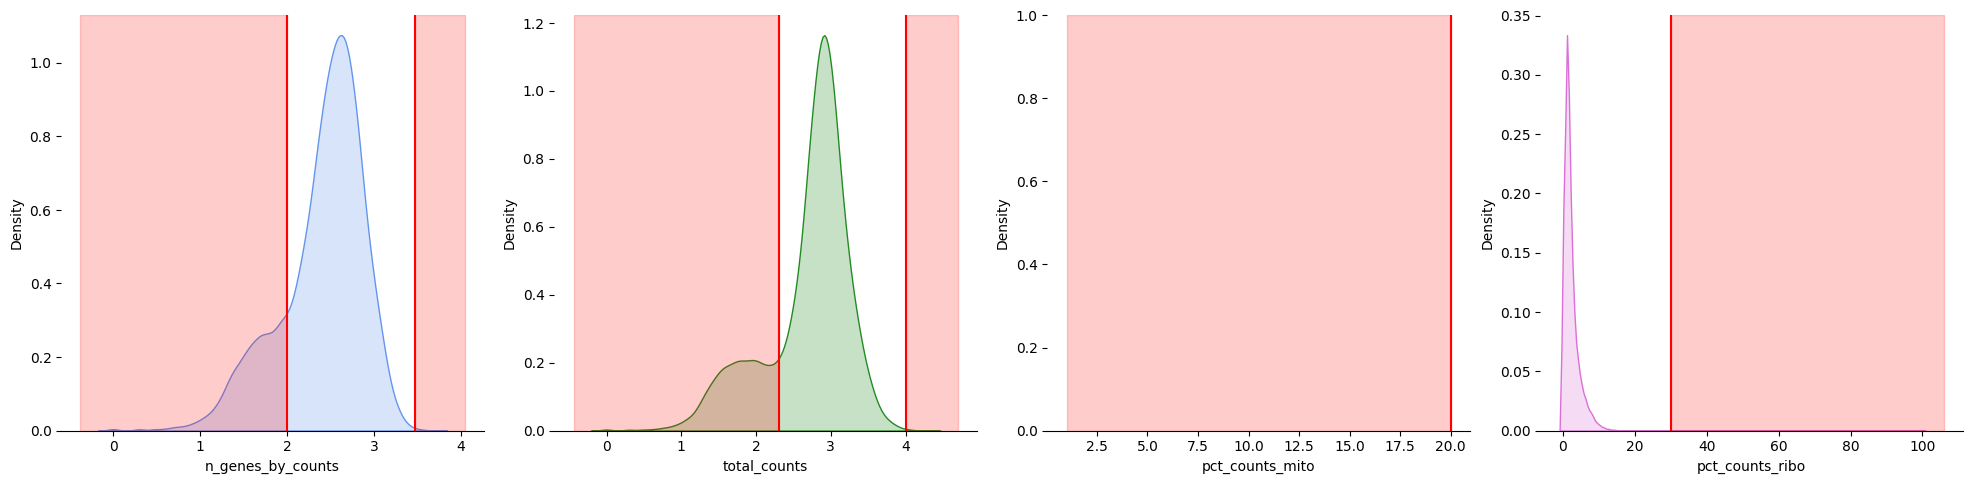

In [179]:
fn.densityQCs(adataObj = adata, hue=None, 
              min_counts = MIN_COUNTS, max_counts = MAX_COUNTS, 
              min_genes = MIN_GENES, max_genes = MAX_GENES, 
              pct_counts_mito = PCT_MITO, pct_counts_ribo = PCT_RIBO)

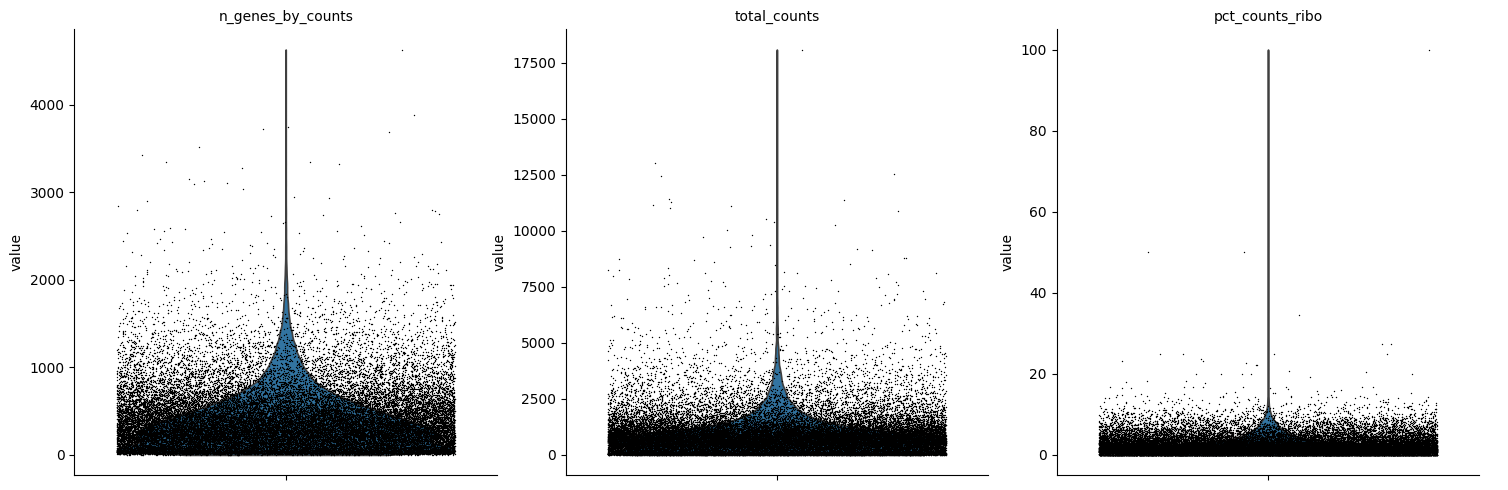

In [180]:
# Plot QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_ribo'], 
            jitter=0.4, multi_panel=True)


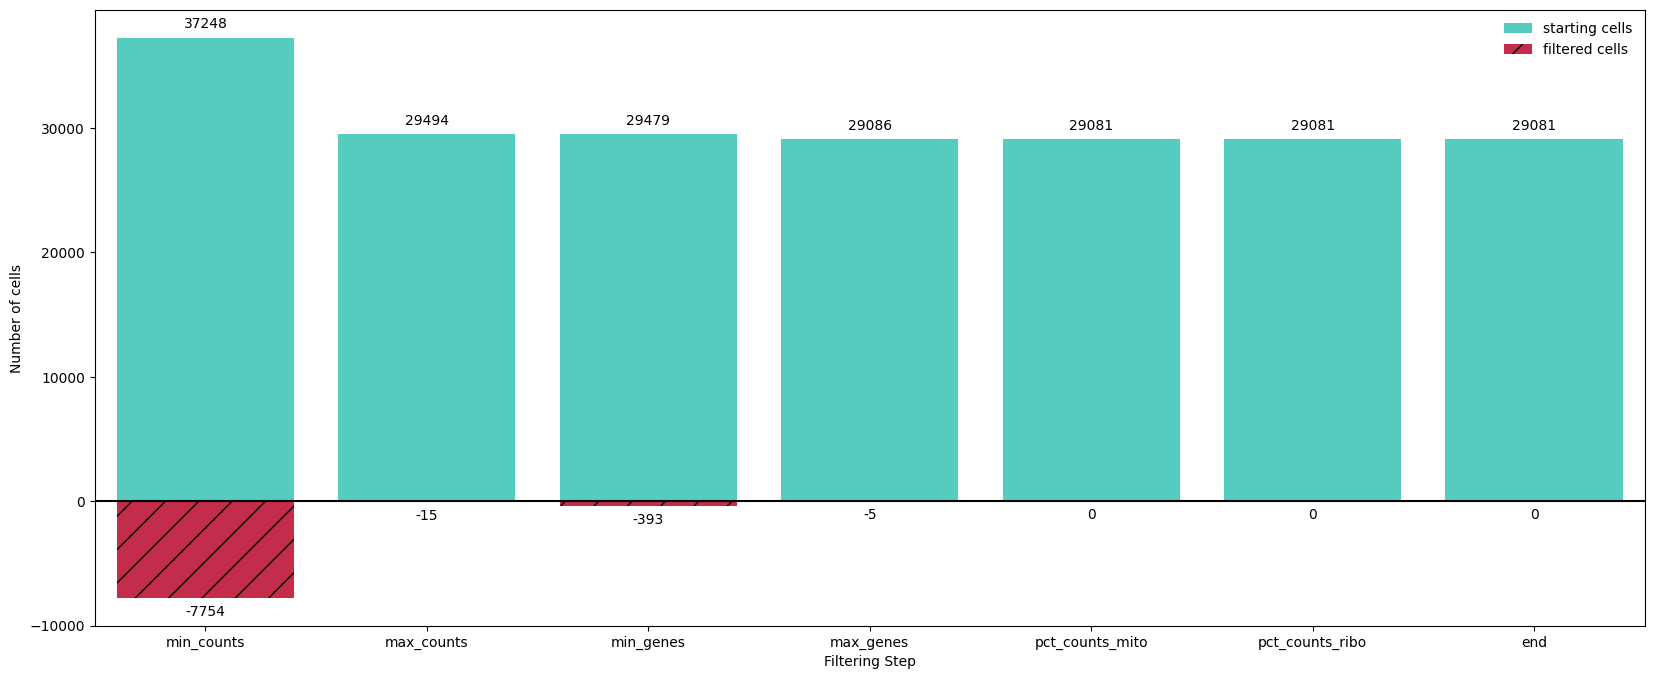

In [181]:
fn.filterCellBarplot(adataObj=adata,
                     min_counts=MIN_COUNTS, max_counts=MAX_COUNTS,
                     min_genes=MIN_GENES, max_genes=MAX_GENES,
                     pct_counts_mito = PCT_MITO, pct_counts_ribo = PCT_RIBO)

In [182]:
gc.collect()

13414

In [183]:
print('\nThe selected filtering parameters are:' 
      '\n Minimum counts: ' , MIN_COUNTS, '\n Maximum counts:' , MAX_COUNTS,
      '\n Minimum genes: ' , MIN_GENES, '\n Maximum genes:' , MAX_GENES,
      '\n Mitocondia: ' , PCT_MITO, '%', '\n Ribosomal: ', PCT_RIBO, '%')

sc.pp.filter_cells(adata, min_genes=MIN_GENES)
sc.pp.filter_cells(adata, max_genes=MAX_GENES)
print('After filtering detected genes: number of cells:', adata.n_obs)

sc.pp.filter_cells(adata, min_counts = MIN_COUNTS)
sc.pp.filter_cells(adata, max_counts = MAX_COUNTS)
print('After filtering on min UMI counts:number of cells:', adata.n_obs)

adata = adata[adata.obs['pct_counts_mito'] < PCT_MITO, :]
print('After filtering on mitochondrial RNA: number of cells:', adata.n_obs)

adata = adata[adata.obs['pct_counts_ribo'] < PCT_RIBO, :]
print('After filtering on ribosomal protein RNA: number of cells:', adata.n_obs)

MIN_CELLS = np.rint((adata.n_obs*PCT_CELLS)/100) 
print('\nGene expressed in less than ', PCT_CELLS, '% cells, corresponding to a number of ', 
     MIN_CELLS, ', are filtered out.')

print('Before gene filtering: number of genes:', adata.n_vars)
sc.pp.filter_genes(adata, min_cells=MIN_CELLS)
print('After gene filtering: number of genes:', adata.n_vars)


The selected filtering parameters are:
 Minimum counts:  200 
 Maximum counts: 10000 
 Minimum genes:  100 
 Maximum genes: 3000 
 Mitocondia:  20 % 
 Ribosomal:  30 %
filtered out 7097 cells that have less than 100 genes expressed
filtered out 16 cells that have more than 3000 genes expressed
After filtering detected genes: number of cells: 30135
filtered out 1050 cells that have less than 200 counts
filtered out 4 cells that have more than 10000 counts
After filtering on min UMI counts:number of cells: 29081
After filtering on mitochondrial RNA: number of cells: 29081
After filtering on ribosomal protein RNA: number of cells: 29081

Gene expressed in less than  0.25 % cells, corresponding to a number of  73.0 , are filtered out.
Before gene filtering: number of genes: 27815
filtered out 17291 genes that are detected in less than 73.0 cells


/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:283: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


After gene filtering: number of genes: 10524


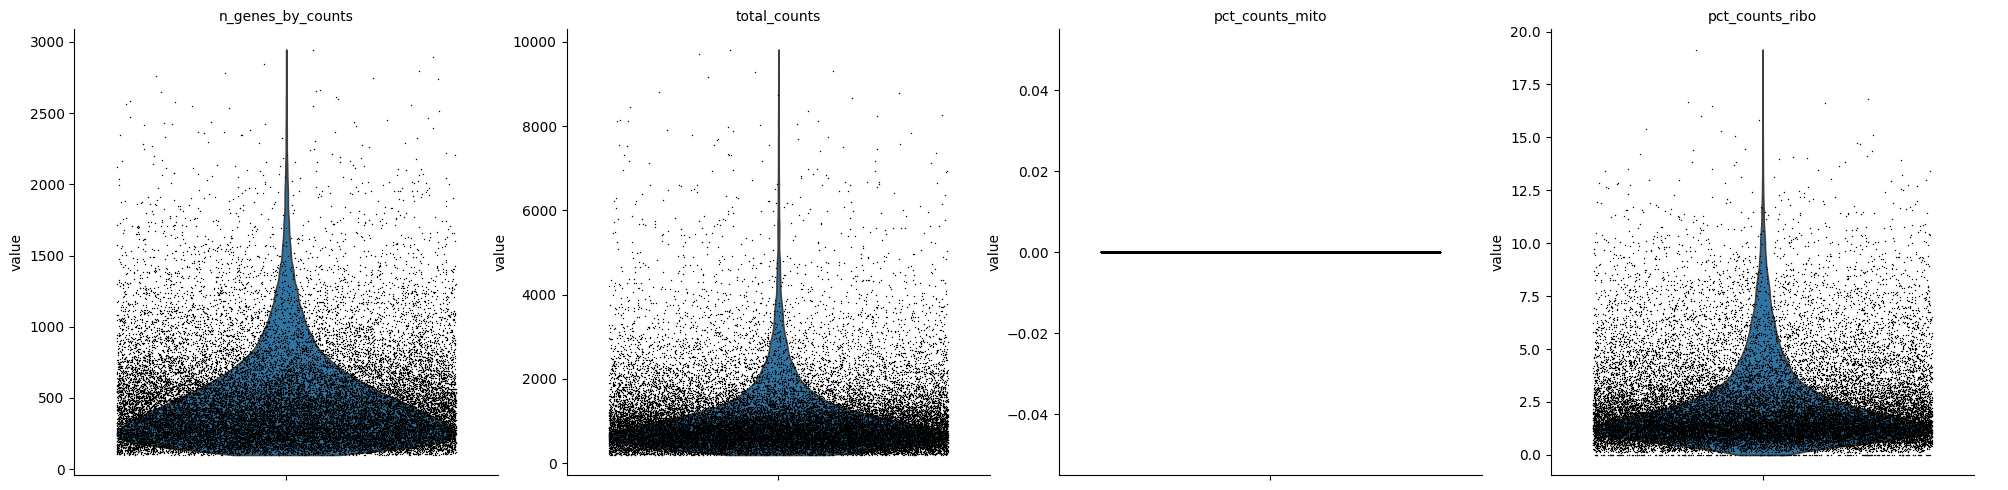

In [184]:
# Plot QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'], 
            jitter=0.4, multi_panel=True)


# Postprocessing

In [185]:
# Save raw counts in a new layer
adata.layers['counts'] = adata.X.copy()

# Normalize data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:01)


In [187]:
%%capture
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


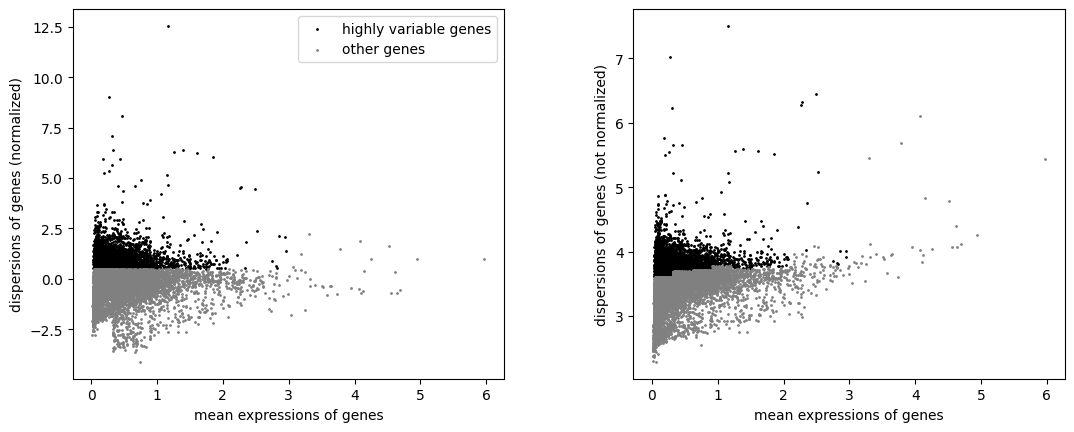

In [188]:
# Plot highly variable genes
sc.pl.highly_variable_genes(adata)

In [189]:
# Set the .raw attribute of AnnData object to the normalized and logarithmized raw gene expression
adata.raw = adata

# Scale data
sc.pp.scale(adata, max_value=10)

In [190]:
# Perform PCA
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:06)


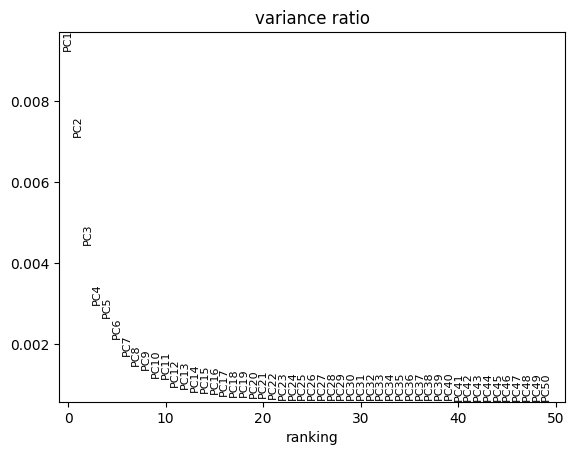

In [191]:
sc.pl.pca_variance_ratio(adata, n_pcs=50)

/beegfs/scratch/tmp/ipykernel_52979/271796758.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


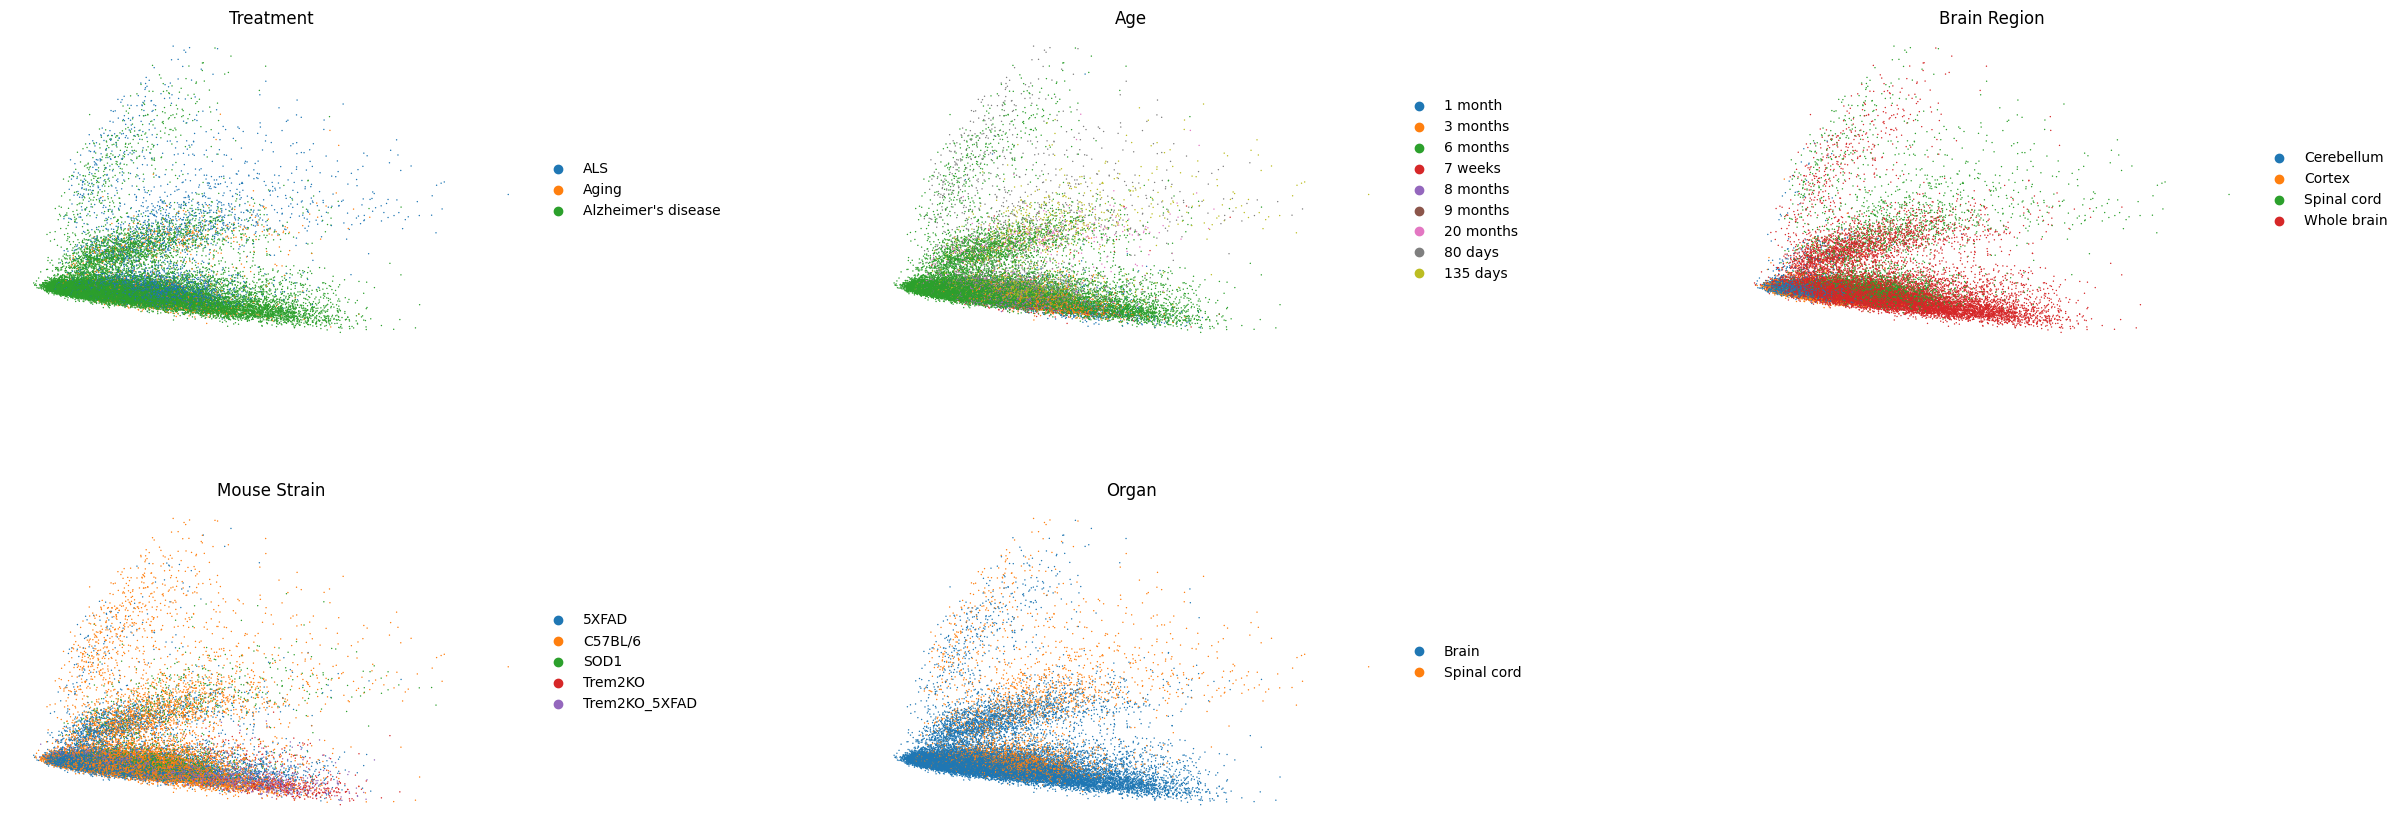

In [192]:
# Plot PCA results
sc.pl.pca(adata, 
          color=['Treatment', 'age', 'region', 'strain', 'organ'],
          ncols=3,
          wspace=0.5,
          hspace=0.5,
          title=['Treatment', 'Age', 'Brain Region', 'Mouse Strain', 'Organ'],
          legend_loc='right margin',
          frameon=False,
          return_fig=True)
plt.tight_layout()
plt.show()

In [193]:
%%capture
# Compute neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
# Perform UMAP Embedding
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:30)


/beegfs/scratch/tmp/ipykernel_52979/154115765.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


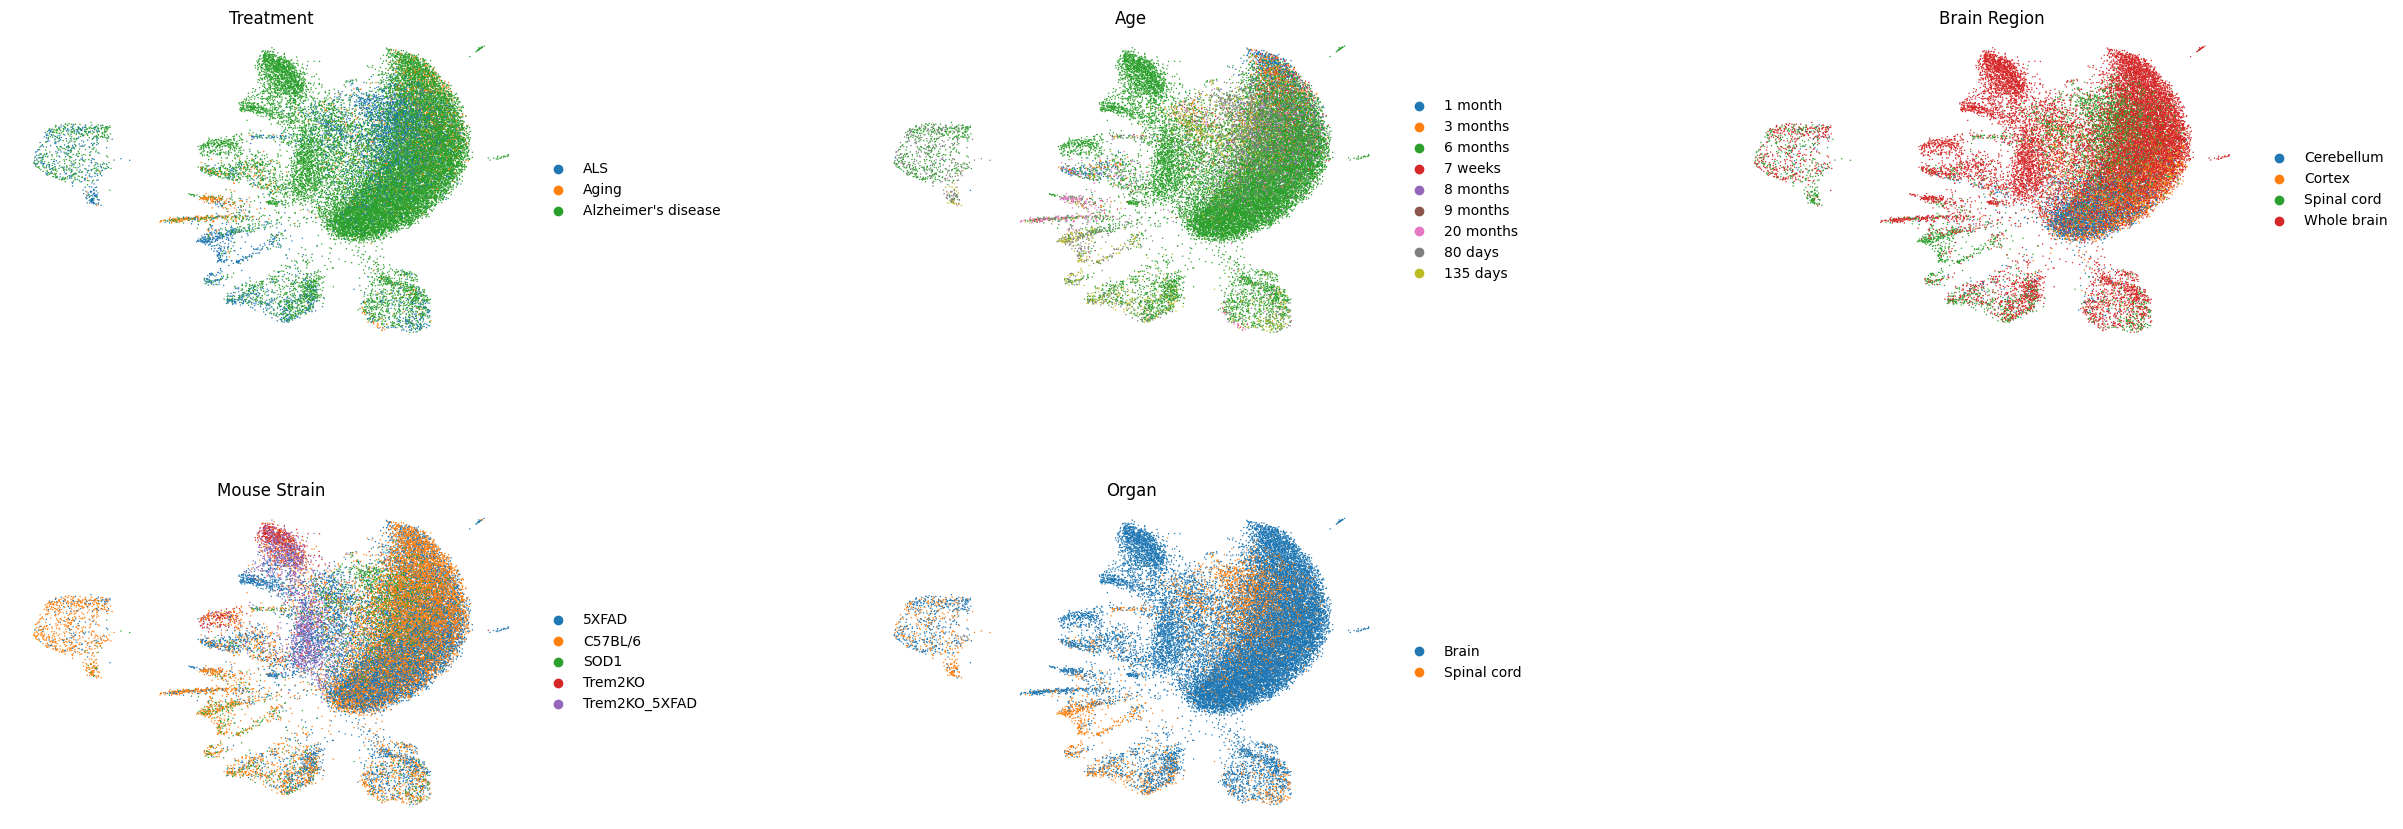

In [194]:
# Plot UMAP results
sc.pl.umap(adata, 
           color=['Treatment', 'age', 'region', 'strain', 'organ'],
           ncols=3,
           wspace=0.5,
           hspace=0.5,
           title=['Treatment', 'Age', 'Brain Region', 'Mouse Strain', 'Organ'],
           legend_loc='right margin',
           frameon=False,
           return_fig=True)
plt.tight_layout()
plt.show()

In [195]:
# Perform clustering
sc.tl.leiden(adata, n_iterations=2, flavor='igraph', directed=False)

running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


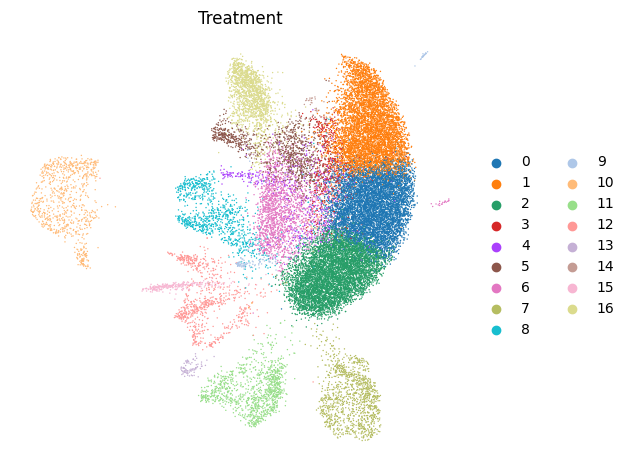

In [196]:
# Plot UMAP results
sc.pl.umap(adata, 
           color=['leiden'],
           wspace=0.5,
           hspace=0.5,
           title=['Treatment', 'Age', 'Brain Region', 'Mouse Strain', 'Organ'],
           legend_loc='right margin',
           frameon=False,
           return_fig=True)
plt.tight_layout()
plt.show()

# Marker genes

In [197]:
%%capture
# Find marker genes
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:22)


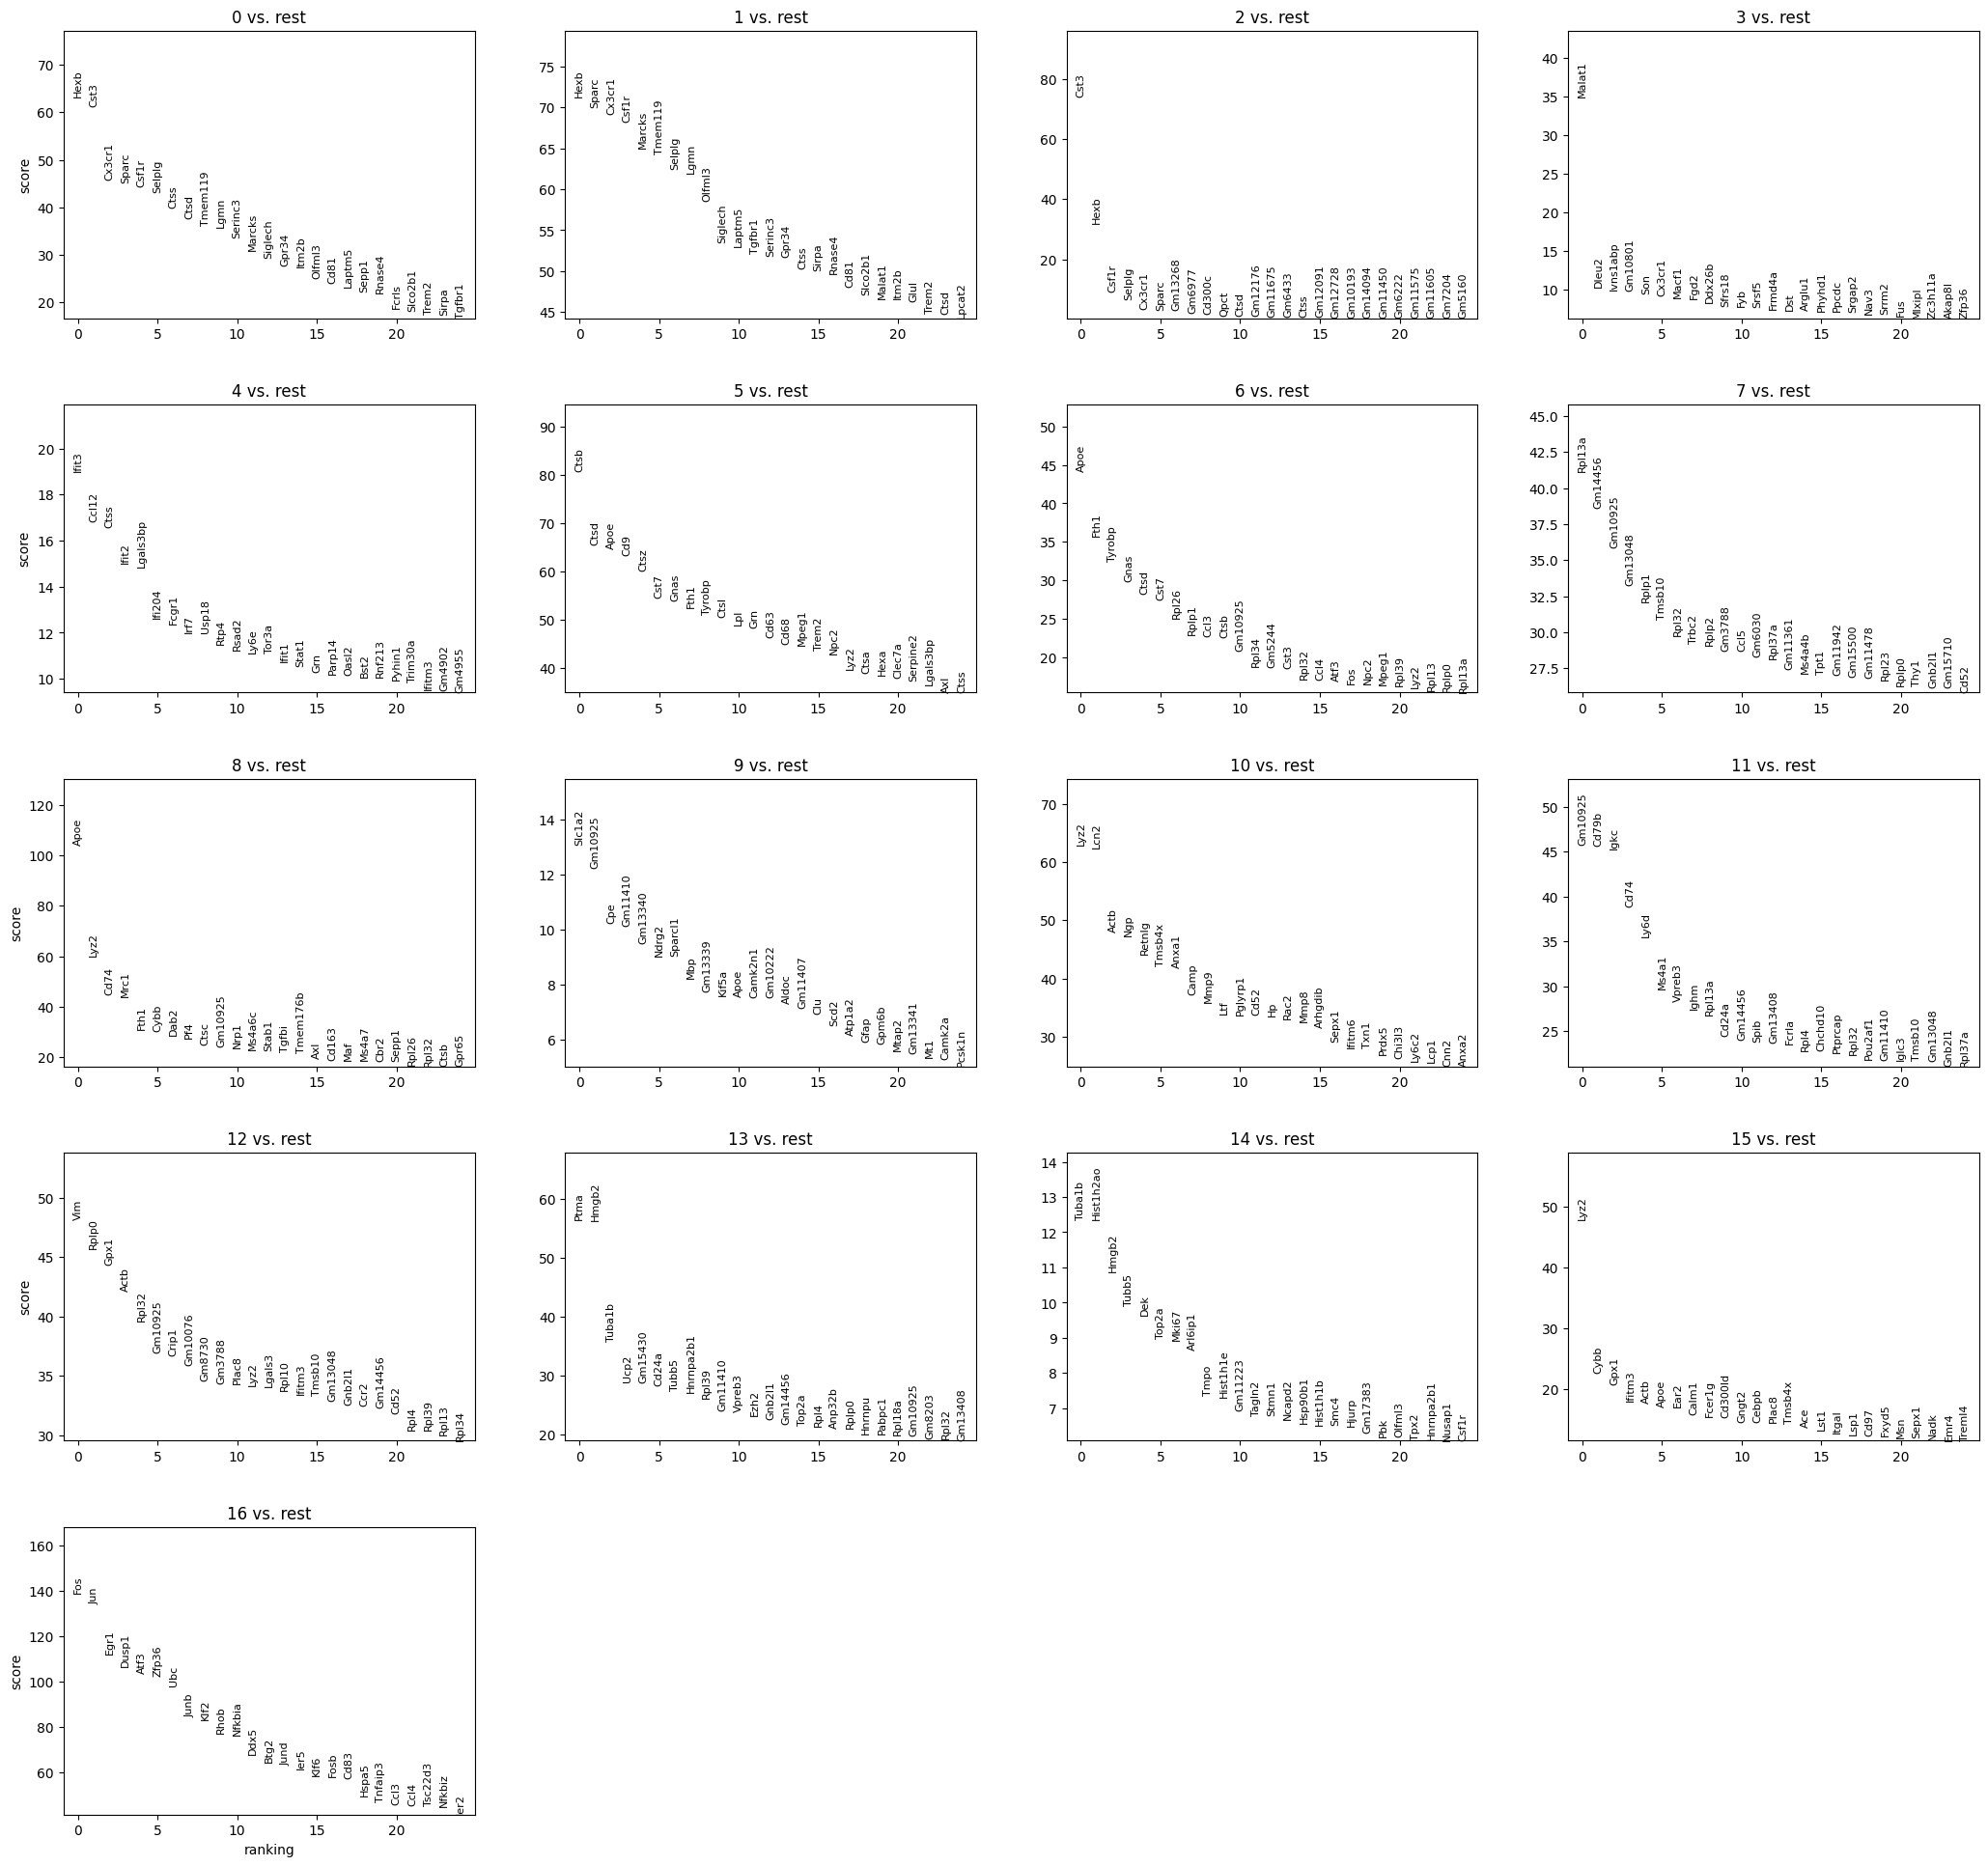

In [198]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [199]:
# Save the results
adata.write('./output/GSE98969_microglia_results.h5ad')

print("Analysis complete. Results saved to 'GSE98969_microglia_results.h5ad'.")

Analysis complete. Results saved to 'GSE98969_microglia_results.h5ad'.


# Differential expression

In [10]:
# Load the saved data back
adata = sc.read('./output/GSE98969_microglia_results.h5ad')

In [11]:
adata.X[0:5, 0:5]

array([[10.        , -0.08821733, -0.26058486, -0.2874926 , -0.30295905],
       [-0.09885704, -0.08821733,  3.4958813 , -0.2874926 , -0.30295905],
       [-0.09885704, -0.08821733, -0.26058486, -0.2874926 , -0.30295905],
       [-0.09885704, -0.08821733, -0.26058486, -0.2874926 , -0.30295905],
       [-0.09885704, -0.08821733, -0.26058486, -0.2874926 , -0.30295905]],
      dtype=float32)

In [12]:
adata

AnnData object with n_obs × n_vars = 29081 × 10524
    obs: 'Treatment', 'age', 'region', 'title', 'strain', 'organ', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'gene_UMI_ratio', 'log1p_gene_UMI_ratio', 'n_genes', 'n_counts', 'leiden'
    var: 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Treatment_colors', 'age_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'organ_colors', 'pca', 'rank_genes_groups', 'region_colors', 'strain_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [13]:
# Create a count matrix from the AnnData object
# We need to use the raw counts, not the normalized data
if 'counts' in adata.layers:
    count_matrix = pd.DataFrame(adata.layers['counts'], index=adata.obs_names, columns=adata.var_names)
else:
    print("Warning: Raw counts not found. Using data from adata.X")
    count_matrix = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)

print(count_matrix.head())

         Aaas  Aacs  Aagab  Aamp  Aars  Aars2  Aarsd1  Aasdh  Aasdhppt  Aatf  \
W620561     2     0      0     0     0      0       0      0         0     0   
W620562     0     0      1     0     0      0       0      0         0     0   
W620563     0     0      0     0     0      0       0      0         0     0   
W620564     0     0      0     0     0      0       0      0         0     0   
W620565     0     0      0     0     0      0       0      0         0     0   

         ...  Zswim7  Zufsp  Zw10  Zwint  Zxdb  Zxdc  Zyg11b  Zyx  Zzef1  Zzz3  
W620561  ...       0      0     0      0     0     0       0    0      0     0  
W620562  ...       0      0     0      0     0     0       0    1      0     0  
W620563  ...       0      0     0      0     0     0       0    0      0     0  
W620564  ...       0      0     0      0     0     0       3    0      0     0  
W620565  ...       0      0     0      0     0     0       0    0      0     0  

[5 rows x 10524 columns]


In [14]:
# Ensure all values are non-negative integers
count_matrix = count_matrix.clip(lower=0).astype(int)

# Create a sample information dataframe
sample_info = adata.obs[['strain']].copy()
sample_info.columns = ['condition']

In [15]:
print(f"Number of samples (cells) in count matrix: {count_matrix.shape[0]}")
print(f"Number of genes in count matrix: {count_matrix.shape[1]}")
print(f"Number of samples in sample info: {len(sample_info)}")

Number of samples (cells) in count matrix: 29081
Number of genes in count matrix: 10524
Number of samples in sample info: 29081


In [16]:
%%capture
# Create DeseqDataSet object
dds = DeseqDataSet(
    counts=count_matrix,
    metadata=sample_info,
    design_factors="condition",
    refit_cooks=True
)

# Run DESeq2 analysis
dds.deseq2()

In [ ]:
%%capture
# Get results - compare 5XFAD to C57BL/6
stat_res = DeseqStats(dds, contrast=["condition", "5XFAD", "C57BL/6"])
stat_res.summary()
results = stat_res.results_df

In [ ]:
# Filter for significantly differentially expressed genes
significant_genes = results[(results['padj'] < 0.05) & (abs(results['log2FoldChange']) > 1)]

print(f"Number of significantly differentially expressed genes: {len(significant_genes)}")

In [ ]:
# Save results to CSV
results.to_csv('./output/deseq2_results_strain_comparison.csv')
significant_genes.to_csv('./output/deseq2_significant_genes_strain_comparison.csv')

         Aaas  Aacs  Aagab  Aamp  Aars  Aars2  Aarsd1  Aasdh  Aasdhppt  Aatf  \
W620561     2     0      0     0     0      0       0      0         0     0   
W620562     0     0      1     0     0      0       0      0         0     0   
W620563     0     0      0     0     0      0       0      0         0     0   
W620564     0     0      0     0     0      0       0      0         0     0   
W620565     0     0      0     0     0      0       0      0         0     0   

         ...  Zswim7  Zufsp  Zw10  Zwint  Zxdb  Zxdc  Zyg11b  Zyx  Zzef1  Zzz3  
W620561  ...       0      0     0      0     0     0       0    0      0     0  
W620562  ...       0      0     0      0     0     0       0    1      0     0  
W620563  ...       0      0     0      0     0     0       0    0      0     0  
W620564  ...       0      0     0      0     0     0       3    0      0     0  
W620565  ...       0      0     0      0     0     0       0    0      0     0  

[5 rows x 10524 columns]
Number 

/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/pydeseq2/dds.py:264: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/pydeseq2/dds.py:483: UserWarning: Every gene contains at least one zero, cannot compute log geometric means. Switching to iterative mode.
  self.fit_size_factors()
Fitting dispersions...
... done in 61.62 seconds.

Fitting MAP dispersions...
... done in 43.70 seconds.



In [ ]:
# Create a volcano plot
plt.figure(figsize=(10, 8))
results['-log10_pvalue'] = -np.log10(results['pvalue'])
sns.scatterplot(data=results, x='log2FoldChange', y='-log10_pvalue', 
                hue=(results['padj'] < 0.05) & (abs(results['log2FoldChange']) > 1))
plt.title('Volcano Plot of DESeq2 Results: 5XFAD vs C57BL/6')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 P-value')
plt.savefig('./output/deseq2_volcano_plot_strain_comparison.png')
plt.close()

# Volcano plots

In [ ]:
def plot_volcano(de_results, comparison, reference_strain):
    plt.figure(figsize=(12, 10))
    
    # Define significance thresholds
    padj_threshold = 0.05
    log2fc_threshold = 1
    
    # Create a color column
    de_results['color'] = 'grey'
    de_results.loc[(de_results['padj'] < padj_threshold) & (de_results['log2FoldChange'] > log2fc_threshold), 'color'] = 'red'
    de_results.loc[(de_results['padj'] < padj_threshold) & (de_results['log2FoldChange'] < -log2fc_threshold), 'color'] = 'blue'
    
    # Plot points
    plt.scatter(de_results['log2FoldChange'], -np.log10(de_results['pvalue']), 
                c=de_results['color'], alpha=0.6, s=20)
    
    # Add labels for top significant genes
    top_genes = de_results[(de_results['padj'] < padj_threshold) & (abs(de_results['log2FoldChange']) > log2fc_threshold)].nlargest(10, 'padj')
    for idx, row in top_genes.iterrows():
        plt.annotate(idx, (row['log2FoldChange'], -np.log10(row['pvalue'])), 
                     xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Add lines for thresholds
    plt.axhline(-np.log10(padj_threshold), color='gray', linestyle='--')
    plt.axvline(-log2fc_threshold, color='gray', linestyle='--')
    plt.axvline(log2fc_threshold, color='gray', linestyle='--')
    
    # Customize the plot
    plt.xlabel('Log2 Fold Change', fontsize=12)
    plt.ylabel('-Log10 P-value', fontsize=12)
    plt.title(f'Volcano Plot: {comparison} vs {reference_strain}', fontsize=14)
    
    # Add a legend
    plt.legend(['Non-significant', 'Upregulated', 'Downregulated'], loc='upper left')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

In [9]:
# Get results for each comparison
comparisons = dds.design_factors['condition'].unique()
reference_strain = 'C57BL/6'  # Assuming C57BL/6 is the reference strain

for comparison in comparisons:
    if comparison != reference_strain:
        stat_res = DeseqStats(dds, contrast=["condition", comparison, reference_strain])
        stat_res.summary()
        results = stat_res.results_df

        # Filter for significantly differentially expressed genes
        significant_genes = results[(results['padj'] < 0.05) & (abs(results['log2FoldChange']) > 1)]
        print(f"Number of significantly differentially expressed genes ({comparison} vs {reference_strain}): {len(significant_genes)}")

        # Plot volcano plot
        plot_volcano(results, comparison, reference_strain)

        # Save results to CSV
        results.to_csv(f'./output/deseq2_results_{comparison}_vs_{reference_strain}.csv')
        significant_genes.to_csv(f'./output/deseq2_significant_genes_{comparison}_vs_{reference_strain}.csv')

NameError: name 'dds' is not defined

# Heatmap

In [ ]:
def plot_heatmap(adata, de_results, n_top_genes=50):
    """
    Create and save a heatmap of top differentially expressed genes.
    
    Parameters:
    - adata: AnnData object containing the expression data
    - de_results: DataFrame containing differential expression results
    - n_top_genes: Number of top differentially expressed genes to include in the heatmap
    """
    # Get top differentially expressed genes
    top_genes = de_results.sort_values('padj').head(n_top_genes).index.tolist()
    
    # Extract expression data for top genes
    expr_data = adata[:, top_genes].layers['log_norm']
    
    # Create a DataFrame with sample names as index and gene names as columns
    heatmap_data = pd.DataFrame(expr_data, index=adata.obs_names, columns=top_genes)
    
    # Z-score normalize the expression data
    heatmap_data_norm = (heatmap_data - heatmap_data.mean()) / heatmap_data.std()
    
    # Set up the matplotlib figure
    plt.figure(figsize=(20, 15))
    
    # Create the heatmap
    sns.heatmap(heatmap_data_norm.T, cmap='viridis', center=0, 
                yticklabels=True, xticklabels=False, 
                cbar_kws={'label': 'Z-score'})
    
    # Customize the plot
    plt.title(f'Top {n_top_genes} Differentially Expressed Genes', fontsize=14)
    plt.ylabel('Genes', fontsize=12)
    plt.xlabel('Samples', fontsize=12)
    
    # Add color bar for strain
    unique_strains = adata.obs['strain'].unique()
    color_map = plt.cm.get_cmap('Set1')(np.linspace(0, 1, len(unique_strains)))
    color_dict = dict(zip(unique_strains, color_map))
    
    strain_colors = [color_dict[strain] for strain in adata.obs['strain']]
    plt.colorbar(plt.cm.ScalarMappable(cmap='Set1'), 
                 ax=plt.gca(), label='Strain', aspect=5, 
                 ticks=np.linspace(0, 1, len(unique_strains)))
    plt.gca().collections[0].colorbar.set_ticklabels(unique_strains)
    
    # Add strain color bar at the top of the heatmap
    ax_top = plt.gca().twiny()
    ax_top.imshow([strain_colors], aspect='auto', extent=[0, len(adata.obs_names), 0, 0.5])
    ax_top.set_xlim(0, len(adata.obs_names))
    ax_top.axis('off')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.savefig('heatmap_top_de_genes.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
plot_heatmap(adata, results, n_top_genes=50)

# Legacy

In [98]:
%%script false --no-raise-error
def load_data(file_path):
    """Load the saved results."""
    adata = sc.read(file_path)
    print(f"Data loaded successfully. Shape: {adata.shape}")
    print(f"Observations: {list(adata.obs_keys())}")
    print(f"Variables: {list(adata.var_keys())}")
    return adata

def prepare_data(adata):
    """Prepare the data for analysis."""
    adata.layers['log_norm'] = adata.X.copy()
    adata.X = adata.layers['counts'].copy()
    return adata

def normalize_pseudobulk(pseudobulk):
    """Normalize pseudo-bulk data."""
    pseudobulk_norm = pseudobulk.copy()
    pseudobulk_norm.X = pseudobulk_norm.X / pseudobulk_norm.X.sum(axis=1, keepdims=True) * 1e6
    pseudobulk_norm.layers['counts'] = pseudobulk_norm.layers['counts'] / pseudobulk_norm.layers['counts'].sum(axis=1, keepdims=True) * 1e6
    pseudobulk_norm.layers['log_norm'] = np.log1p(pseudobulk_norm.X)
    return pseudobulk_norm

def log_transform(pseudobulk_norm):
    """Log transform the normalized data."""
    pseudobulk_log = pseudobulk_norm.copy()
    pseudobulk_log.X = np.log2(pseudobulk_log.X + 1)
    return pseudobulk_log

def plot_volcano(de_results):
    """Create and save a volcano plot."""
    plt.figure(figsize=(10, 8))
    plt.scatter(de_results['log2fc'], -np.log10(de_results['pvalue']), alpha=0.5)
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-Log10 P-value')
    plt.title('Volcano Plot: 5XFAD vs C57BL/6')
    plt.show()

def plot_heatmap(adata, genes):
    """Create and save a heatmap of top differentially expressed genes."""
    plt.figure(figsize=(12, 10))
    sc.pl.heatmap(adata, var_names=genes, groupby='strain', show_gene_labels=True, cmap='viridis', dendrogram=False)
    plt.show()
    

def save_results(pseudobulk, pseudobulk_norm, pseudobulk_log, de_results):
    """Save analysis results to CSV files."""
    pseudobulk.write_csvs('pseudobulk_raw_counts.csv')
    pseudobulk_norm.write_csvs('pseudobulk_normalized.csv')
    pd.DataFrame(pseudobulk_log.X.T, index=pseudobulk_log.var_names, columns=pseudobulk_log.obs_names).to_csv('pseudobulk_log_transformed.csv')
    de_results.to_csv('differential_expression_results.csv')

In [127]:
%%script false --no-raise-error
def create_pseudobulk(adata, group_by, replicate_by='title'):
    """Create pseudo-bulk data from single-cell data with replicates."""
    adata.obs[group_by] = pd.Categorical(adata.obs[group_by])
    adata.obs[replicate_by] = pd.Categorical(adata.obs[replicate_by])
    
    # Create a combined grouping variable
    adata.obs['group_replicate'] = adata.obs[group_by].astype(str) + '_' + adata.obs[replicate_by].astype(str)
    
    indicator = pd.get_dummies(adata.obs['group_replicate'])
    
    pseudobulk = ad.AnnData(
        X=indicator.values.T @ adata.X,
        obs=pd.DataFrame(index=indicator.columns),
        var=adata.var.copy()
    )
    
    # Extract group and replicate information
    pseudobulk.obs[group_by] = pseudobulk.obs.index.str.split('_').str[0]
    pseudobulk.obs[replicate_by] = pseudobulk.obs.index.str.split('_').str[1]
    
    for layer in adata.layers.keys():
        pseudobulk.layers[layer] = indicator.values.T @ adata.layers[layer]
    
    return pseudobulk

# Create and process pseudo-bulk data with replicates
pseudobulk = create_pseudobulk(adata, 'strain', 'title')

In [ ]:
%%script false --no-raise-error
# Perform differential expression analysis on pseudobulk data
print("Performing differential expression analysis on pseudobulk data...")

# Create count matrix from pseudobulk data
count_matrix = pd.DataFrame(pseudobulk.X, index=pseudobulk.obs_names, columns=pseudobulk.var_names)

print(count_matrix.head())

# Ensure all values are non-negative integers
count_matrix = count_matrix.clip(lower=0).astype(int)

# Create sample information dataframe
sample_info = pd.DataFrame(index=pseudobulk.obs_names)
sample_info['strain'] = pseudobulk.obs['strain']
sample_info['replicate'] = pseudobulk.obs['title']

# Check if we have enough samples for each strain
strain_counts = sample_info['strain'].value_counts()
if (strain_counts < 2).any():
    print("Error: Insufficient replicates for DESeq2 analysis.")
    print("Each strain must have at least 2 samples.")
    print("Consider using a different statistical method or increasing sample size.")
else:
    # Create DeseqDataSet object
    try:
        dds = DeseqDataSet(
            counts=count_matrix,
            metadata=sample_info,
            design_factors="strain",
            refit_cooks=True
        )

        # Run DESeq2 analysis
        dds.deseq2()
        
        # Get results (comparing each strain to the reference level)
        reference_strain = sample_info['strain'].value_counts().index[0]  # Use the most common strain as reference
        results = {}
        for strain in sample_info['strain'].unique():
            if strain != reference_strain:
                stat_res = DeseqStats(dds, contrast=["strain", strain, reference_strain])
                stat_res.summary()
                results[strain] = stat_res.results_df

        # Combine all results
        de_results = pd.concat(results.values(), keys=results.keys(), names=['comparison'])
        de_results = de_results.reset_index(level='comparison')

        # Filter for significantly differentially expressed genes
        significant_genes = de_results[(de_results['padj'] < 0.05) & (abs(de_results['log2FoldChange']) > 1)]

        print(f"Number of significantly differentially expressed genes: {len(significant_genes)}")

        # Save results to CSV
        de_results.to_csv('deseq2_results_pseudobulk.csv')
        significant_genes.to_csv('deseq2_significant_genes_pseudobulk.csv')

        print("DESeq2 analysis on pseudobulk data complete. Results saved to CSV files.")

        # Create a volcano plot for pseudobulk results
        plt.figure(figsize=(12, 8))
        de_results['-log10_pvalue'] = -np.log10(de_results['pvalue'])
        sns.scatterplot(data=de_results, x='log2FoldChange', y='-log10_pvalue', 
                        hue='comparison', style=(de_results['padj'] < 0.05) & (abs(de_results['log2FoldChange']) > 1))
        plt.title('Volcano Plot of DESeq2 Results (Pseudobulk): Strain Comparisons')
        plt.xlabel('Log2 Fold Change')
        plt.ylabel('-Log10 P-value')
        plt.savefig('deseq2_volcano_plot_pseudobulk.png')
        plt.close()

        print("Volcano plot for pseudobulk analysis saved as 'deseq2_volcano_plot_pseudobulk.png'.")

    except ValueError as e:
        print(f"Error in DESeq2 analysis: {str(e)}")
        print("The analysis could not be performed.")
        print("Consider using a different statistical method or checking your input data.")


In [ ]:
%%script false --no-raise-error

def plot_volcano(de_results, comparison, reference_strain):
    """Create and save an enhanced volcano plot."""
    plt.figure(figsize=(12, 10))
    
    # Define significance thresholds
    padj_threshold = 0.05
    log2fc_threshold = 1
    
    # Create a color column
    de_results['color'] = 'grey'
    de_results.loc[(de_results['padj'] < padj_threshold) & (de_results['log2FoldChange'] > log2fc_threshold), 'color'] = 'red'
    de_results.loc[(de_results['padj'] < padj_threshold) & (de_results['log2FoldChange'] < -log2fc_threshold), 'color'] = 'blue'
    
    # Plot points
    plt.scatter(de_results['log2FoldChange'], -np.log10(de_results['pvalue']), 
                c=de_results['color'], alpha=0.6, s=20)
    
    # Add labels for top significant genes
    top_genes = de_results[(de_results['padj'] < padj_threshold) & (abs(de_results['log2FoldChange']) > log2fc_threshold)].nlargest(10, 'padj')
    for idx, row in top_genes.iterrows():
        plt.annotate(idx, (row['log2FoldChange'], -np.log10(row['pvalue'])), 
                     xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Add lines for thresholds
    plt.axhline(-np.log10(padj_threshold), color='gray', linestyle='--')
    plt.axvline(-log2fc_threshold, color='gray', linestyle='--')
    plt.axvline(log2fc_threshold, color='gray', linestyle='--')
    
    # Customize the plot
    plt.xlabel('Log2 Fold Change', fontsize=12)
    plt.ylabel('-Log10 P-value', fontsize=12)
    plt.title(f'Volcano Plot: {comparison} vs {reference_strain}', fontsize=14)
    
    # Add a legend
    plt.legend(['Non-significant', 'Upregulated', 'Downregulated'], loc='upper left')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Plot for each comparison
reference_strain = sample_info['strain'].value_counts().index[0]  # Use the most common strain as reference
for comparison in de_results['comparison'].unique():
    plot_volcano(de_results[de_results['comparison'] == comparison], comparison, reference_strain)

In [ ]:
%%script false --no-raise-error

def plot_heatmap(de_results, pseudobulk, n_top_genes=50):
    """
    Create and save a heatmap of top differentially expressed genes.
    
    Parameters:
    - de_results: DataFrame containing differential expression results
    - pseudobulk: AnnData object containing log-transformed pseudobulk data
    - n_top_genes: Number of top differentially expressed genes to include in the heatmap
    """
    # Get top differentially expressed genes
    top_genes = de_results.sort_values('padj').head(n_top_genes).index.tolist()
    
    # Extract expression data for top genes
    expr_data = pseudobulk[:, top_genes].X
    
    # Create a DataFrame with sample names as index and gene names as columns
    heatmap_data = pd.DataFrame(expr_data, index=pseudobulk.obs_names, columns=top_genes)
    
    # Z-score normalize the expression data
    heatmap_data_norm = (heatmap_data - heatmap_data.mean()) / heatmap_data.std()
    
    # Set up the matplotlib figure
    plt.figure(figsize=(20, 20))  # Swapped width and height
    
    # Create the heatmap
    sns.heatmap(heatmap_data_norm.T, cmap='viridis', center=0, 
                yticklabels=True, xticklabels=pseudobulk.obs['strain'], 
                cbar_kws={'label': 'Z-score'})
    
    # Customize the plot
    plt.title(f'Top {n_top_genes} Differentially Expressed Genes', fontsize=14)
    plt.ylabel('Genes', fontsize=12)
    plt.xlabel('Samples', fontsize=12)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Call the function
plot_heatmap(de_results, pseudobulk)

In [ ]:
# def read_mars_seq_file_in_chunks(filename, chunksize=10000):
#     total_rows = sum(1 for _ in pd.read_csv(filename, sep='\t', compression='gzip', chunksize=chunksize))
    
#     pbar = tqdm(total=total_rows, desc="Reading file", unit="rows")
#     for chunk in pd.read_csv(filename, sep='\t', compression='gzip', index_col=0, chunksize=chunksize):
#         pbar.update(len(chunk))
#         yield chunk
#     pbar.close()

# def process_mars_seq_files(mars_seq_files, metadata_dict, chunksize=10000):
#     adata = None
#     obs_names_counter = {}
    
#     for file in tqdm(mars_seq_files, desc="Processing files", unit="file"):
#         print(f"\nProcessing file: {file}")
#         gsm_id = os.path.basename(file).split('_')[0]
        
#         for i, chunk in enumerate(read_mars_seq_file_in_chunks(file, chunksize)):
#             # Make observation names unique within the file
#             chunk.index = [f"{gsm_id}_{idx}" for idx in chunk.index]
            
#             # Ensure observation names are unique across all files
#             new_obs_names = []
#             for name in chunk.index:
#                 if name in obs_names_counter:
#                     obs_names_counter[name] += 1
#                     new_name = f"{name}_{obs_names_counter[name]}"
#                 else:
#                     obs_names_counter[name] = 0
#                     new_name = name
#                 new_obs_names.append(new_name)
            
#             chunk.index = new_obs_names
            
#             current_adata = ad.AnnData(chunk.T)
            
#             # Add metadata
#             if gsm_id in metadata_dict:
#                 for key, value in metadata_dict[gsm_id].items():
#                     current_adata.obs[key] = value
#             else:
#                 print(f"Warning: No metadata found for {gsm_id}")
            
#             if adata is None:
#                 adata = current_adata
#             else:
#                 adata = ad.concat([adata, current_adata], join='outer', fill_value=0)
            
#             # Clear temporary variables
#             del chunk, current_adata
#             gc.collect()
        
#         gc.collect()
    
#     return adata

# adata = process_mars_seq_files(mars_seq_files, metadata_dict)
# print(adata)